In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os


2025-05-20 22:23:59.661614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747779839.884993      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747779839.955962      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# -------------------------------------------
# 2. Basic Settings and Data Paths
# -------------------------------------------
dataset_path = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = os.path.join(dataset_path, "train")
test_dir = os.path.join(dataset_path, "valid")
batch_size = 32
img_size = 224
epochs = 3  # Increased for ResNet

In [3]:
# -------------------------------------------
# 3. Data Preparation and Generation
# -------------------------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [4]:
# -------------------------------------------
# 4. Build CNN Model
# -------------------------------------------
def build_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(train_generator.num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [5]:
# -------------------------------------------
# 5. Build ResNet Model with Improvements
# -------------------------------------------
def build_resnet_model():
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3)
    )
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),  # Increased units
        layers.BatchNormalization(),
        layers.Dropout(0.4),  # Adjusted dropout
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(train_generator.num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [7]:
# -------------------------------------------
# 6. Build Inception-ResNet-V2 Model
# -------------------------------------------
def build_inception_model():
    base_model = InceptionResNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3)
    )
    
        
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(train_generator.num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [9]:
# -------------------------------------------
# 7. Train Models
# -------------------------------------------
# Callbacks for ResNet
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=1e-6)

In [12]:
# Train Inception-ResNet-V2
inception_model = build_inception_model()
print("\n--- Training Inception-ResNet-V2 Model ---")
history_inception = inception_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=1,  # Keep 1 epoch for Inception
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size)


--- Training Inception-ResNet-V2 Model ---
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 1480s 591ms/step - accuracy: 0.7989 - loss: 0.7580 - val_accuracy: 0.9843 - val_loss: 0.0522


In [13]:
# Train CNN
cnn_model = build_cnn_model()
print("\n--- Training CNN Model ---")
history_cnn = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=1,  # Keep 1 epoch for CNN
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Training CNN Model ---
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 913s 413ms/step - accuracy: 0.3179 - loss: 2.4007 - val_accuracy: 0.7086 - val_loss: 0.8975


In [10]:
# Train ResNet
resnet_model = build_resnet_model()
print("\n--- Training ResNet Model ---")
history_resnet = resnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=1,  
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[early_stopping, reduce_lr])


I0000 00:00:1747779989.433779      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747779989.434462      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Training ResNet Model ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747780043.774095     126 service.cc:148] XLA service 0x7af9ec003160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747780043.775283     126 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747780043.775306     126 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747780048.519845     126 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747780070.287251     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

2196/2196 ━━━━━━━━━━━━━━━━━━━━ 1396s 601ms/step - accuracy: 0.7648 - loss: 0.8864 - val_accuracy: 0.9772 - val_loss: 0.0680 - learning_rate: 1.0000e-04



=== Evaluating Models ===

Evaluating CNN Model...
550/550 ━━━━━━━━━━━━━━━━━━━━ 34s 63ms/step - accuracy: 0.7062 - loss: 0.9118

Model CNN Test Accuracy: 0.7086, Test Loss: 0.8973
550/550 ━━━━━━━━━━━━━━━━━━━━ 32s 58ms/step

Detailed Classification Report for CNN:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.86      0.46      0.60       504
                                 Apple___Black_rot       0.53      0.84      0.65       497
                          Apple___Cedar_apple_rust       0.83      0.68      0.75       440
                                   Apple___healthy       0.70      0.68      0.69       502
                               Blueberry___healthy       0.81      0.80      0.81       454
          Cherry_(including_sour)___Powdery_mildew       0.89      0.71      0.79       421
                 Cherry_(including_sour)___healthy       0.84      0.82      0.83       45

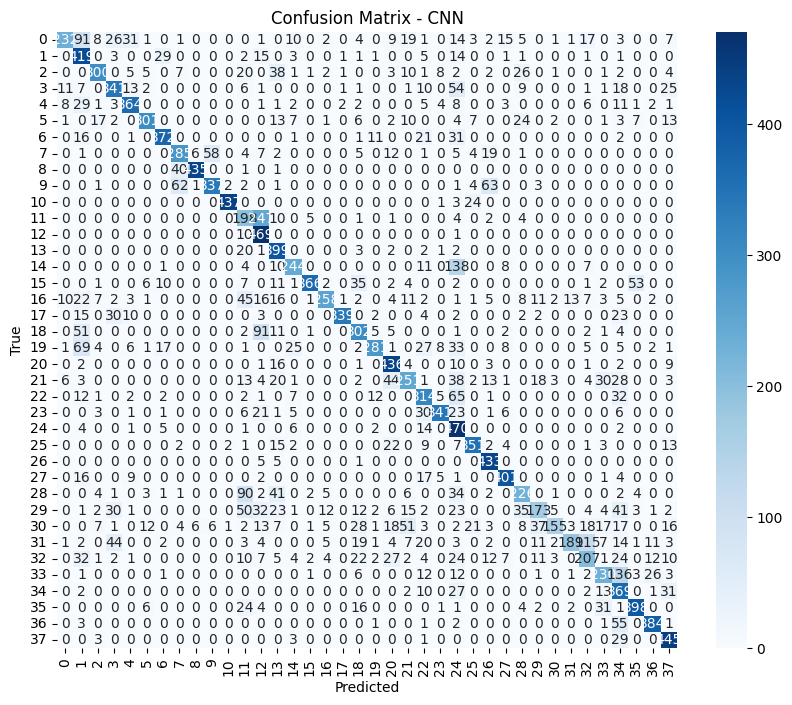


Evaluating ResNet Model...
550/550 ━━━━━━━━━━━━━━━━━━━━ 46s 83ms/step - accuracy: 0.9834 - loss: 0.0573

Model ResNet Test Accuracy: 0.9772, Test Loss: 0.0680
550/550 ━━━━━━━━━━━━━━━━━━━━ 52s 87ms/step

Detailed Classification Report for ResNet:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.96      0.98       504
                                 Apple___Black_rot       0.92      1.00      0.96       497
                          Apple___Cedar_apple_rust       1.00      0.98      0.99       440
                                   Apple___healthy       0.98      1.00      0.99       502
                               Blueberry___healthy       0.99      0.99      0.99       454
          Cherry_(including_sour)___Powdery_mildew       1.00      0.99      0.99       421
                 Cherry_(including_sour)___healthy       0.99      0.98      0.98       456
Corn_(maize)___C

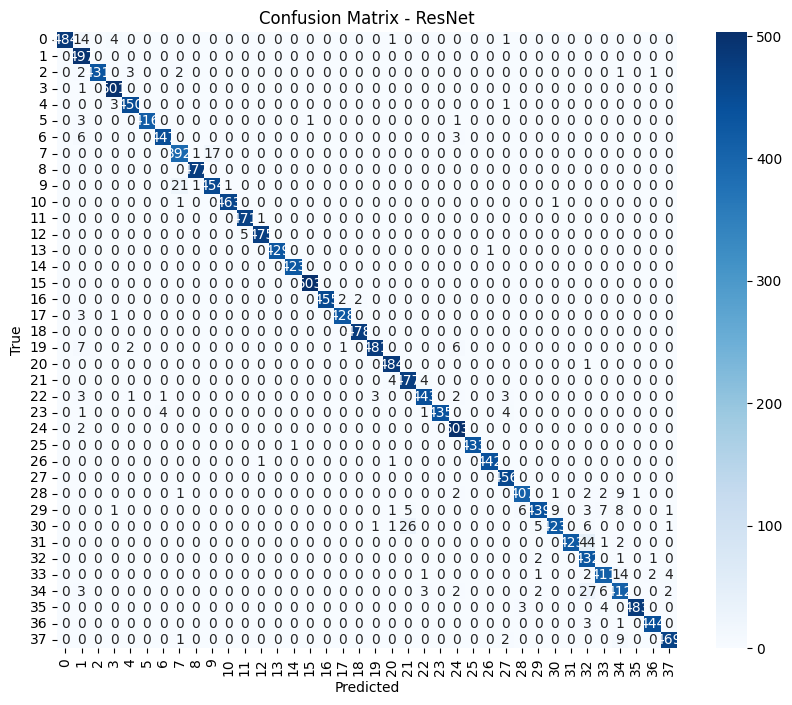


Evaluating Inception-ResNet-V2 Model...
550/550 ━━━━━━━━━━━━━━━━━━━━ 84s 152ms/step - accuracy: 0.9904 - loss: 0.0346

Model InceptionResNetV2 Test Accuracy: 0.9844, Test Loss: 0.0522
550/550 ━━━━━━━━━━━━━━━━━━━━ 105s 169ms/step

Detailed Classification Report for InceptionResNetV2:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      1.00      1.00       504
                                 Apple___Black_rot       0.99      1.00      0.99       497
                          Apple___Cedar_apple_rust       1.00      0.99      1.00       440
                                   Apple___healthy       1.00      0.99      1.00       502
                               Blueberry___healthy       1.00      1.00      1.00       454
          Cherry_(including_sour)___Powdery_mildew       1.00      0.99      0.99       421
                 Cherry_(including_sour)___healthy       1.00      1.0

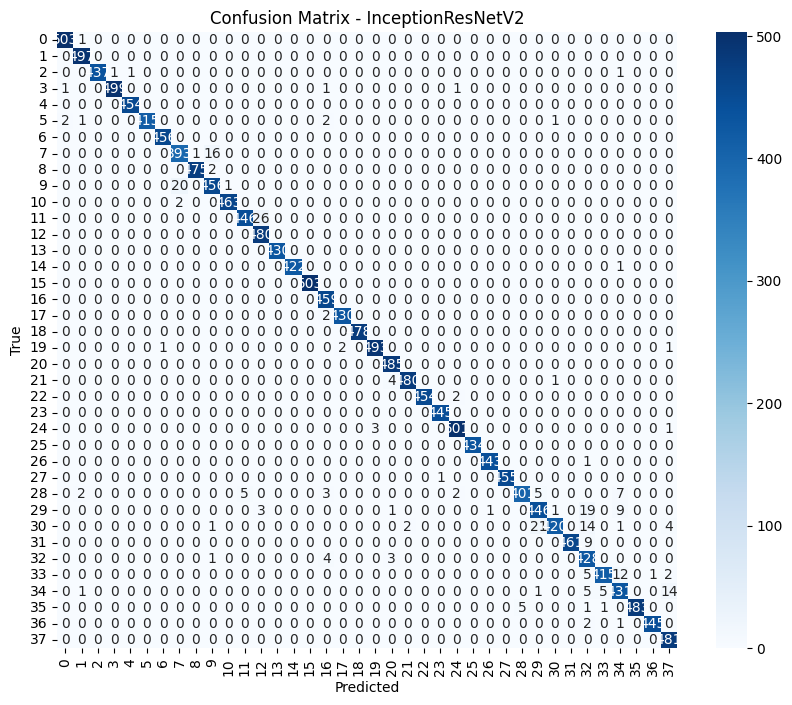

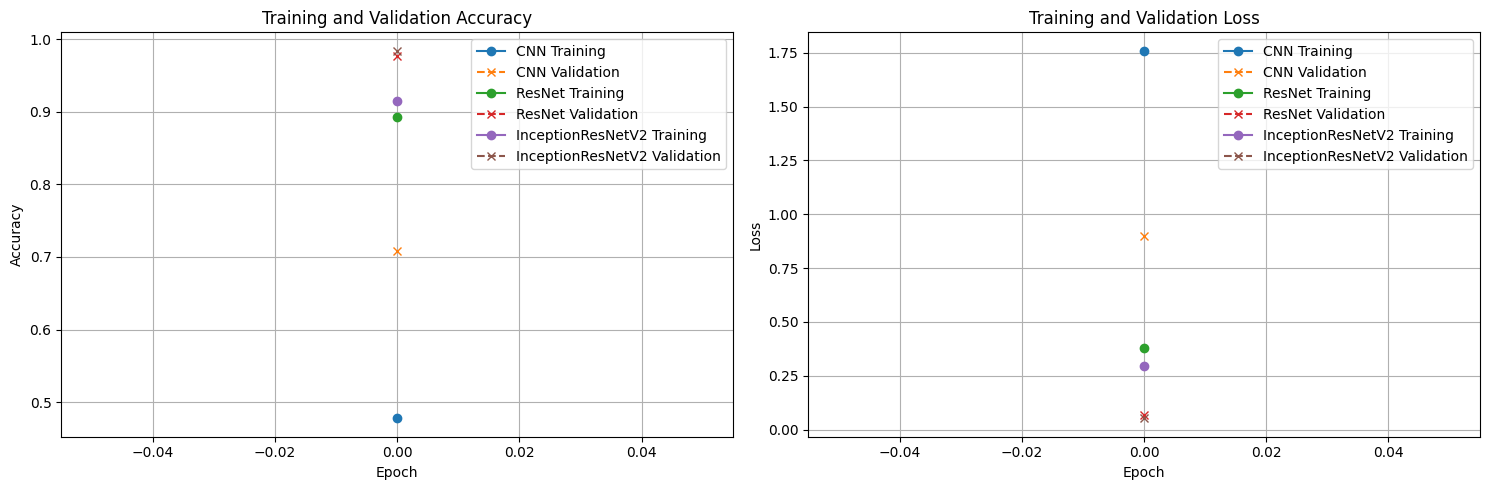


Model Comparison Table:
               Model  Test Accuracy  Test Loss
0                CNN       0.708627   0.897286
1             ResNet       0.977180   0.067971
2  InceptionResNetV2       0.984350   0.052198
Comparison table saved as 'model_comparison.csv'


In [14]:
# -------------------------------------------
# 8. Evaluation Functions
# -------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# List to store evaluation results
results = []

def evaluate_model(model, history, model_name, test_generator):
    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_generator)
    print(f'\nModel {model_name} Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}')
    
    # Store results
    results.append({
        'Model': model_name,
        'Test Accuracy': test_acc,
        'Test Loss': test_loss
    })
    
    # Predictions and classification report
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    print(f"\nDetailed Classification Report for {model_name}:")
    print(classification_report(test_generator.classes, y_pred_classes,
                                target_names=list(test_generator.class_indices.keys())))
    
    # Confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix(test_generator.classes, y_pred_classes), 
                annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()  # Display the plot
    plt.close()
    
    return history, test_acc, test_loss

def plot_comparative_metrics(histories, model_names):
    plt.figure(figsize=(15, 5))
    
    # Training and validation accuracy
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], marker='o', label=f'{name} Training')
        plt.plot(history.history['val_accuracy'], marker='x', linestyle='--', label=f'{name} Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Training and validation loss
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], marker='o', label=f'{name} Training')
        plt.plot(history.history['val_loss'], marker='x', linestyle='--', label=f'{name} Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('comparative_metrics.png')
    plt.show()  # Display the plot
    plt.close()

def save_comparison_table(results):
    df = pd.DataFrame(results)
    df.to_csv('model_comparison.csv', index=False)
    print("\nModel Comparison Table:")
    print(df)
    print("Comparison table saved as 'model_comparison.csv'")

# -------------------------------------------
# 9. Execute Evaluation
# -------------------------------------------
print("\n=== Evaluating Models ===")

# Lists to store histories
histories = []
model_names = ["CNN", "ResNet", "InceptionResNetV2"]

# Evaluate CNN
print("\nEvaluating CNN Model...")
history_cnn, cnn_acc, cnn_loss = evaluate_model(cnn_model, history_cnn, "CNN", test_generator)
histories.append(history_cnn)

# Evaluate ResNet
print("\nEvaluating ResNet Model...")
history_resnet, resnet_acc, resnet_loss = evaluate_model(resnet_model, history_resnet, "ResNet", test_generator)
histories.append(history_resnet)

# Evaluate Inception-ResNet-V2
print("\nEvaluating Inception-ResNet-V2 Model...")
history_inception, inception_acc, inception_loss = evaluate_model(inception_model, history_inception, "InceptionResNetV2", test_generator)
histories.append(history_inception)

# Plot comparative metrics
plot_comparative_metrics(histories, model_names)

# Save comparison table
save_comparison_table(results)

In [15]:
# -------------------------------------------
# 10. Save Models
# -------------------------------------------
os.makedirs('saved_models', exist_ok=True)

cnn_model.save('saved_models/plant_disease_cnn.h5')
print("\nCNN Model saved at: saved_models/plant_disease_cnn.h5")

resnet_model.save('saved_models/plant_disease_resnet.h5')
print("ResNet Model saved at: saved_models/plant_disease_resnet.h5")

inception_model.save('saved_models/plant_disease_inception.h5')
print("Inception-ResNet-V2 Model saved at: saved_models/plant_disease_inception.h5")


CNN Model saved at: saved_models/plant_disease_cnn.h5
ResNet Model saved at: saved_models/plant_disease_resnet.h5
Inception-ResNet-V2 Model saved at: saved_models/plant_disease_inception.h5


In [16]:
import os
print("Saved files:", os.listdir('saved_models'))

Saved files: ['plant_disease_inception.h5', 'plant_disease_cnn.h5', 'plant_disease_resnet.h5']


In [17]:
print(os.listdir('/kaggle/working/saved_models'))

['plant_disease_inception.h5', 'plant_disease_cnn.h5', 'plant_disease_resnet.h5']


**Test**

In [18]:
import os
print(os.listdir('/kaggle/working/saved_models'))

['plant_disease_inception.h5', 'plant_disease_cnn.h5', 'plant_disease_resnet.h5']
